In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
from simulate import generateData
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from scipy.optimize import linprog

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=4000

# number of (Gaussian) covariates
p=20

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [3]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.000000000000001

In [4]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [5]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([ 91.,  97.,  58.,  68.,  63.,  51.,  62.,  57.,  49.,  42.,  45.,
         46.,  42.,  44.,  41.,  42.,  41.,  44.,  34.,  39.,  46.,  39.,
         37.,  31.,  38.,  37.,  36.,  32.,  31.,  36.,  26.,  35.,  26.,
         31.,  33.,  23.,  35.,  22.,  34.,  36.,  24.,  26.,  23.,  32.,
         33.,  24.,  40.,  36.,  30.,  31.,  33.,  32.,  33.,  37.,  26.,
         28.,  20.,  26.,  29.,  23.,  25.,  30.,  25.,  30.,  23.,  30.,
         30.,  37.,  27.,  35.,  42.,  26.,  34.,  32.,  25.,  30.,  43.,
         37.,  49.,  39.,  33.,  39.,  32.,  39.,  44.,  52.,  42.,  32.,
         37.,  39.,  47.,  48.,  55.,  68.,  58.,  73.,  62.,  70., 102.]),
 array([0.00099991, 0.01098515, 0.02097039, 0.03095563, 0.04094087,
        0.05092611, 0.06091135, 0.07089658, 0.08088182, 0.09086706,
        0.1008523 , 0.11083754, 0.12082278, 0.13080801, 0.14079325,
        0.15077849, 0.16076373, 0.17074897, 0.18073421, 0.19071944,
        0.20070468, 0.21068992, 0.22067516, 0.2306604 , 0.24

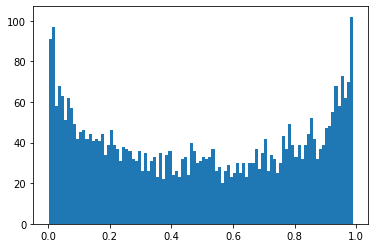

In [6]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([  3.,   0.,   0.,   1.,   1.,   1.,   7.,   4.,   2.,   5.,   8.,
          8.,   6.,  16.,  14.,   7.,  13.,  21.,  22.,  24.,  21.,  23.,
         26.,  21.,  30.,  42.,  40.,  38.,  46.,  54.,  52.,  59.,  61.,
         63.,  75.,  74.,  89.,  84., 101.,  93.,  99.,  94.,  98.,  98.,
        104., 104., 115., 116., 116.,  87.,  93.,  89., 101., 103.,  86.,
         94., 105.,  78.,  78.,  88.,  60.,  54.,  52.,  55.,  65.,  56.,
         51.,  42.,  47.,  30.,  34.,  28.,  23.,  25.,  28.,  22.,  19.,
         18.,  20.,  11.,  13.,   8.,   6.,   8.,   4.,   3.,   4.,   3.,
          1.,   2.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   2.,   0.]),
 array([-6.90683989, -6.76128059, -6.61572129, -6.47016198, -6.32460268,
        -6.17904338, -6.03348408, -5.88792478, -5.74236548, -5.59680618,
        -5.45124688, -5.30568758, -5.16012827, -5.01456897, -4.86900967,
        -4.72345037, -4.57789107, -4.43233177, -4.28677247, -4.14121317,
        -3.99565387, -3.85009456, -3.704

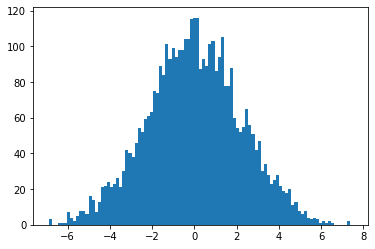

In [7]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [10]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.400869029256595
97.5th percentile: 4.362467653723666


In [94]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################
# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.10,0.70,0.05) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []
kappa_list=[] #just checking
sample_size_list=[] #just checking

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 25
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    
    for i in range(B):
        subSample = df.sample(n=sampleSize) #should we add replace=True
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 

        #change target from 0,1 to -1,1 respectively. 
        #subSample['y']=np.where(subSample['y'] == 1, 1 , -1)

        #according to one source, we need to scale now.
        X = subSample.iloc[:,:-1] 
        y= subSample.iloc[:,-1]
        tmp = X.values
        tmp = sc.fit_transform(tmp)

        n,p = tmp.shape

        xx = np.array(y.values.reshape(-1,1) * tmp)
        t = y.values

        A_ub = np.append(xx, t.reshape(-1,1), 1)
        b_ub = np.repeat(-1, A_ub.shape[0]).reshape(-1,1)

        c_obj = np.repeat(1, A_ub.shape[1])

        res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, options={"disp": False, "maxiter":10}) #iterations are quite low
     
        if res.success:
            nMleDNE +=1 #There is linear separability between classes
        
        #print('next')



    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    kappa_list.append(kappa)
    sample_size_list.append(sampleSize)

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are non linearly separable!')

print(kappaProportion)

Method Failed, All Subsamples are non linearly separable!
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.08, 0.08, 0.12, 0.24]


In [95]:
#Getting the index of the first non-zero value in kappa proportion
mleIdx = np.argmax(np.array(kappaProportion) > 0)
#Looping until the difference between kappas of MLE and non-MLE is less than 0.001
while (kappaProportion[mleIdx]-kappaProportion[mleIdx-1] > 0.001 and mleIdx !=0):
    #Collecting the kappa value corresponding to first non-zero kapp proportion
    kappa1 = kappaArray[mleIdx]
    kappa2 = kappaArray[mleIdx-1]
    #Generating the interval size
    kappaInterval = (kappa1-kappa2)/20
    kappaArray = np.arange(kappa2,kappa1,round(kappaInterval,6))
    print(kappaArray)
    # Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
    kappaProportion = []
    kappa_list=[] #just checking
    sample_size_list=[] #just checking

    # Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
    for kappa in kappaArray:

        # Set sample size to n_j =p / k_j (rounding off to nearest integer)
        # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
        sampleSize = int(round(p/kappa))

        # Here, we draw several samples and check to see if the MLE exists. B is the number of
        # rounds of sampling
        B = 25

        # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
        # is initially set to 0
        nMleDNE = 0

        for i in range(B):
            subSample = df.sample(n=sampleSize) #should we add replace=True
            subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 

            #change target from 0,1 to -1,1 respectively. 
            #subSample['y']=np.where(subSample['y'] == 1, 1 , -1)

            #according to one source, we need to scale now.
            X = subSample.iloc[:,:-1] 
            y= subSample.iloc[:,-1]
            tmp = X.values
            tmp = sc.fit_transform(tmp)

            n,p = tmp.shape

            xx = np.array(y.values.reshape(-1,1) * tmp)
            t = y.values

            A_ub = np.append(xx, t.reshape(-1,1), 1)
            b_ub = np.repeat(-1, A_ub.shape[0]).reshape(-1,1)

            c_obj = np.repeat(1, A_ub.shape[1])

            res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, options={"disp": False, "maxiter":10}) #iterations are quite low

            if res.success:
                nMleDNE +=1 #There is linear separability between classes

            #print('next')



        # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
        propMleDNE = nMleDNE/B
        kappaProportion.append(propMleDNE)
        kappa_list.append(kappa)
        sample_size_list.append(sampleSize)

    # Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
    # the MLE does not exist
    uIdx = 0
    for kappaProp in kappaProportion:
        if kappaProp>=0.5:
            uIdx = kappaProportion.index(kappaProp) # index of kappa_j
            break
    if uIdx != 0:
        uKappa = kappaArray[uIdx] # kappa_j
        lKappa = kappaArray[uIdx-1] # kappa_j-1
    else:
        print('Method Failed, All Subsamples are non linearly separable!')

    print(kappaProportion)
mleIdx = np.argmax(np.array(kappaProportion) > 0)
print("Appropriate value of Kappa: ",kappaArray[mleIdx])


[0.4    0.4025 0.405  0.4075 0.41   0.4125 0.415  0.4175 0.42   0.4225
 0.425  0.4275 0.43   0.4325 0.435  0.4375 0.44   0.4425 0.445  0.4475]
Method Failed, All Subsamples are non linearly separable!
[0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.415    0.415125 0.41525  0.415375 0.4155   0.415625 0.41575  0.415875
 0.416    0.416125 0.41625  0.416375 0.4165   0.416625 0.41675  0.416875
 0.417    0.417125 0.41725  0.417375 0.4175  ]
Method Failed, All Subsamples are non linearly separable!
[0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.0]
Appropriate value of Kappa:  0.4153750000000001
